# NLP_State Gov Complaint / Question Classification Project

### Проект группы развития медиааналитики в г. Москва

## Задача

Необходимо обучить модель, которая будет присваивать сообщениям пользователей класс - *жалоба / вопрос.*

## Методология проекта

1. Сделать первичную обработку данных.
2. Обучить модели классификации, начиная с baselines.
3. Оценить качество классификации разных моделей по метрикам качества выбрать лучшую.
4. Сделать выводы.

## Данные

В качестве данных предложен файл, содержащий в себе вопросы в адрес государственных и муниципальных органов, которые пользователи оставили в социальных сетях. Файл с данными находиться [здесь](https://docs.google.com/spreadsheets/d/1VoONQ5Li6hYFv1SGmUKEWdnm7wYDmWYi/edit?usp=sharing&ouid=117398067332429699807&rtpof=true&sd=true).


In [299]:
import fasttext.util
import lightgbm as lgb
import nltk
import pandas as pd
from gensim.models import word2vec

# загрузка модели Word2Vec для английского языка
nltk.download('stopwords')
import warnings

from tqdm import tqdm

warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
tqdm.pandas()

# pipeline позволяет объединить в один блок трансформер и модель, что упрощает написание кода и улучшает его читаемость
# TfidfVectorizer преобразует тексты в числовые вектора, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте

from sklearn.pipeline import Pipeline
import warnings

import matplotlib.pyplot as plt
import numpy as np
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from pymystem3 import Mystem
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from tqdm import tqdm
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('snowball_data')
nltk.download('perluniprops')
nltk.download('universal_tagset')
nltk.download('nonbreaking_prefixes')
nltk.download('wordnet')

warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package snowball_data to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package snowball_data is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading pa

In [300]:
# в nltk много токенизаторов
from nltk import tokenize
dir(tokenize)[:16]

['BlanklineTokenizer',
 'LegalitySyllableTokenizer',
 'LineTokenizer',
 'MWETokenizer',
 'NLTKWordTokenizer',
 'PunktSentenceTokenizer',
 'RegexpTokenizer',
 'ReppTokenizer',
 'SExprTokenizer',
 'SpaceTokenizer',
 'StanfordSegmenter',
 'SyllableTokenizer',
 'TabTokenizer',
 'TextTilingTokenizer',
 'ToktokTokenizer',
 'TreebankWordDetokenizer']

In [301]:
from nltk.corpus import stopwords

# смотрим, какие языки есть
stopwords.fileids()

['arabic',
 'azerbaijani',
 'basque',
 'bengali',
 'catalan',
 'chinese',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'hebrew',
 'hinglish',
 'hungarian',
 'indonesian',
 'italian',
 'kazakh',
 'nepali',
 'norwegian',
 'portuguese',
 'romanian',
 'russian',
 'slovene',
 'spanish',
 'swedish',
 'tajik',
 'turkish']

In [302]:
# выведем все стоп-слова русского языка
sw = stopwords.words('russian')
print(sw)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

## Загрузка и изучение данных

In [287]:
df = pd.read_excel("C:\\Users\\HOME\\PycharmProjects\\Data_scientist_NLP_данные.xlsx")
df.head(20)

,Дата,Категория,Тема,Муниципалитет,Текст
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс..."
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ..."
5,2022-07-19 05:28:42.565,Жалоба,Экология,Ивнянский р-н,'Когда будет приведён в порядок пруд в центре ...
6,2022-05-17 06:14:50.682,Жалоба,ЖКХ,Котлас,'Обращаюсь от имени одиноких престарелых людей...
7,2022-03-09 11:12:59.799,Жалоба,ЖКХ,Красноярский р-н,"'Добрый день,Игорь Юрьевич!С 4 марта 2022 года..."
8,2022-03-06 14:06:36.410,Вопрос,ЖКХ,Камызякский р-н,'А про Камызякский район забыли?
9,2022-01-06 20:53:11.803,Вопрос,Здравоохранение/Медицина,Архангельск г,"'Здравствуйте!Скажите пожалуйста,правда ли,что..."


In [288]:
df.columns

Index(['Дата', 'Категория', 'Тема', 'Муниципалитет', 'Текст'], dtype='object')

In [289]:
# rename the columns
d = df.rename(columns={'Категория': 'category',
                        'Тема': 'topic',
                        'Муниципалитет': 'municipality',
                        'Текст': 'text',
                       'Дата': 'date'})

# print the DataFrame to verify the column names
print(d.columns)
d

Index(['date', 'category', 'topic', 'municipality', 'text'], dtype='object')


,date,category,topic,municipality,text
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс..."
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ..."
...,...,...,...,...,...
29544,2022-04-11 08:42:35.514,Вопрос,Общественный транспорт,Октябрьский г,'Добрый день.Почему подорожала плата за проезд...
29545,2022-05-04 07:38:28.007,Вопрос,"МФЦ ""Мои документы""",Миасс г,'Миасс. Девочки подскажите номер телефона пф о...
29546,2022-04-15 19:15:52.086,Вопрос,Социальное обслуживание и защита,Уфа г,'Здравствуйте почему пришел отказ?<br>db7ced5b...
29547,2022-07-11 07:51:28.096,Вопрос,Общественный транспорт,Белгород г,'А НАЗАД С КАКИМ ИНТЕРВОЛОМ БУДУТ ЕЗДИТЬ АВТОБ...


### Изучим целевую переменную label на предмет дисбаланса

С дисбалансом таргета можно бороться разными способами:
* провести upsampling, downsampling;
* добавить при обучении модели аргумент ```class_weight = 'balanced'```

В данном проекте мы будем использовать второй способ; в целях тренировки сделаем downsampling.

In [290]:
d['category'].unique()

array(['Вопрос', 'Жалоба'], dtype=object)

In [291]:
# проверка таргета на дисбаланс
d['category'].value_counts()

Вопрос    24549
Жалоба     5000
Name: category, dtype: int64

In [292]:
d['category'].value_counts() / (len(df))

Вопрос    0.83079
Жалоба    0.16921
Name: category, dtype: float64

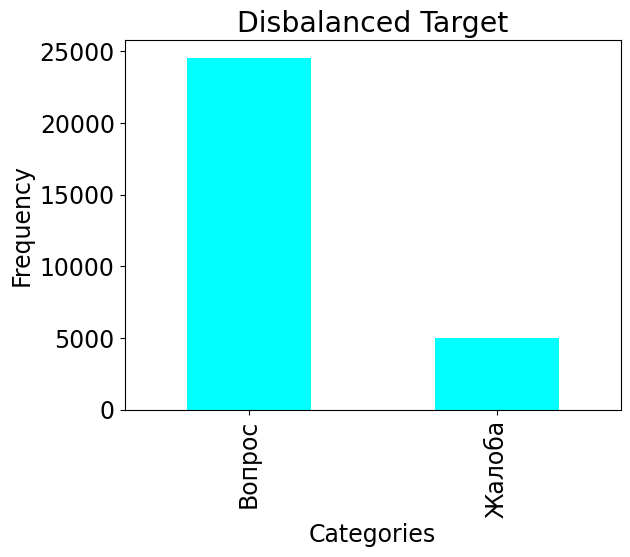

In [293]:
d['category'].value_counts().plot(kind='bar', color=['cyan'])

plt.title('Disbalanced Target')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show();

In [294]:
# перекодируем таргет цифрами
d['label'] = d['category'].replace({'Вопрос': 'question', 'Жалоба': 'complaint'})
d.head(30)

,date,category,topic,municipality,text,label
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...,question
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс...",question
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...,question
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?,question
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ...",question
5,2022-07-19 05:28:42.565,Жалоба,Экология,Ивнянский р-н,'Когда будет приведён в порядок пруд в центре ...,complaint
6,2022-05-17 06:14:50.682,Жалоба,ЖКХ,Котлас,'Обращаюсь от имени одиноких престарелых людей...,complaint
7,2022-03-09 11:12:59.799,Жалоба,ЖКХ,Красноярский р-н,"'Добрый день,Игорь Юрьевич!С 4 марта 2022 года...",complaint
8,2022-03-06 14:06:36.410,Вопрос,ЖКХ,Камызякский р-н,'А про Камызякский район забыли?,question
9,2022-01-06 20:53:11.803,Вопрос,Здравоохранение/Медицина,Архангельск г,"'Здравствуйте!Скажите пожалуйста,правда ли,что...",question


In [295]:
# проверим данные на пропуски
d.isna().sum()

date             0
category         0
topic           11
municipality     0
text             0
label            0
dtype: int64

В данных имеется доля пропусков в колонке topic. Так как число пропусков < 10% от количества наблюдений, то пропуски можно безопасно удалить.

In [279]:
d = d.dropna()

In [280]:
d.isna().sum()

date            0
category        0
topic           0
municipality    0
text            0
label           0
dtype: int64

In [148]:
d['label'].unique()

array(['question', 'complaint'], dtype=object)

In [219]:
d.head(30)

,date,category,topic,municipality,text,label
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,245,'Вид из окна потрясающий (пр. С. Юлаева напрот...,question
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,41,"'[id294938415:bp-88767010_4|Αнастасия], Здравс...",question
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,236,'[club53367440:bp-53367440_121743|Министерство...,question
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,236,'Здравствуйте когда будет выплата ДВ?,question
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,254,"'Девочки всем привет,у меня такой вопрос получ...",question
5,2022-07-19 05:28:42.565,Жалоба,Экология,90,'Когда будет приведён в порядок пруд в центре ...,complaint
6,2022-05-17 06:14:50.682,Жалоба,ЖКХ,122,'Обращаюсь от имени одиноких престарелых людей...,complaint
7,2022-03-09 11:12:59.799,Жалоба,ЖКХ,130,"'Добрый день,Игорь Юрьевич!С 4 марта 2022 года...",complaint
8,2022-03-06 14:06:36.410,Вопрос,ЖКХ,99,'А про Камызякский район забыли?,question
9,2022-01-06 20:53:11.803,Вопрос,Здравоохранение/Медицина,10,"'Здравствуйте!Скажите пожалуйста,правда ли,что...",question


### Перед тем, как приступить к предобработке текста и обучению моделей, выделим 3 жалобы и 3 вопроса в качестве реальных данных для теста.

In [304]:
# Select 3 complaints and 3 questions randomly and save them to separate dataframes
complaints = d[d['label'] == 'complaint'].sample(n=3)
questions = d[d['label'] == 'question'].sample(n=3)

# Save the complaints and questions dataframes to separate files
complaints.to_csv("C:\\Users\\HOME\\PycharmProjects\\NLP_GovComplaintQuestionClassification\\complaints_test.csv", index=False)
questions.to_csv("C:\\Users\\HOME\\PycharmProjects\\NLP_GovComplaintQuestionClassification\\questions_test.csv", index=False)

# Remove the complaints and questions rows from the original dataframe
d = d.drop(complaints.index)
d = d.drop(questions.index)

### Изучим текстовые данные

In [305]:
corpus = list(d['text'])
corpus

["'Вид из окна потрясающий (пр. С. Юлаева напротив Юбилейной). Когда наконец уберете эту помойку(сараи, постройки)",
 "'[id294938415:bp-88767010_4|Αнастасия], Здравствуйте, подскажите как оспорить результаты по отказу пособия с 8 до 17? Насчитали большую сумму, а по факту меньше. Как быть?спасибо",
 "'[club53367440:bp-53367440_121743|Министерство], здравствуйте. С 3 до 7 уже направили? Сегодня же только 14",
 "'Здравствуйте когда будет выплата ДВ?",
 "'Девочки всем привет,у меня такой вопрос получила пособие вместо 12444,7 с копейками,детские вчера переоформила которые до 1,5,нам вчера исполнился 1 год,когда придет остальная часть?",
 "'Когда будет приведён в порядок пруд в центре Ивни по улице Луговая? Не просто покос рогоза в январе перед журналистами, а качественная чистка водоёма от рогоза, который превращает пруд в центре посёлка в болото и сборник мусора.",
 "'Обращаюсь от имени одиноких престарелых людей жителей микрорайона Лименды города Котласа. по поводу нововведения передачи

In [306]:
def lemmatize(text):
    m = Mystem()
    lemm_list = m.lemmatize(text)
    lemm_text = "".join(lemm_list)

    return lemm_text

def clear_text(text):
    clr = re.sub(r'[^а-яА-ЯёЁ ]', ' ', text)
    cleared_text = " ".join(clr.split())
    return cleared_text

In [307]:
# тестируем функции
print("Исходный текст:", corpus[153])
print()
print("Очищенный и лемматизированный текст:", lemmatize(clear_text(corpus[153])))

Исходный текст: 'А,он будет ездить по старому маршруту,через ЛИСКИ,не подскажите???

Очищенный и лемматизированный текст: а он быть ездить по старый маршрут через лиски не подсказывать



In [308]:
m = MorphAnalyzer()

# убираем все небуквенные символы
regex = re.compile("[А-Яа-яA-z]+")


def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

In [309]:
print(d.text[0])

'Вид из окна потрясающий (пр. С. Юлаева напротив Юбилейной). Когда наконец уберете эту помойку(сараи, постройки)


In [310]:
# # создаем новый список для хранения очищенных и лемматизированных текстов
# processed_corpus = []
#
# # проходим по каждому тексту в корпусе, применяем функции лемматизации и очистки текста
# for text in corpus:
#     processed_text = lemmatize(clear_text(text))
#     processed_corpus.append(processed_text)

#### Код выше - корректный, но ввиду большого объема данных циклом обходить весь корпус занимает много времени. Сам по себе Mystem() очень долгий. Нужно какое-то более оптимальное решение.

#### Метод ```@lru_cashe``` создает для функции lemmatize кэш указанного размера, что позволяет в целом ускорить лемматизацию текста (что очень полезно, так как лемматизация - ресурсоемкий процесс).

In [311]:
# create a MorphAnalyzer instance
m = MorphAnalyzer()

# set up regex to extract words from text
regex = re.compile("[А-Яа-яA-z]+")

# set up stopwords
mystopwords = stopwords.words('russian')

# set up lemmatization cache
@lru_cache(maxsize=100000)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

# define text preprocessing function
def clean_text(text):
    # extract words from text
    tokens = regex.findall(text.lower())

    # lemmatize the words
    lemmas = [lemmatize_word(token) for token in tokens]

    # remove stopwords and short words
    words = [word for word in lemmas if word not in mystopwords and len(word) > 3]

    return words

In [312]:
print(*clean_text(d.text[3]))

здравствуйте выплата


In [313]:
text = d.text[13]
cleaned_text = clean_text(text)
print(cleaned_text)

['вопрос', 'администрация', 'город', 'деньга', 'почему', 'содержание', 'животное']


#### Нам нужно предобработать большой объем текста, помимо кэширования может помочь распараллеливание, например, методом Pool библиотеки multiprocessing:

In [229]:
# %%time
# # N = 200
# # with Pool(4) as p:
# #     lemmas = list(tqdm(p.imap(clean_text, data['text']), total=N))
#
# with Pool(4) as p:
#     lemmas = list(tqdm(p.imap(clean_text, d['text']), total=len(d)))
#
# d['lemmas'] = lemmas
# d.sample(5)

Код выше - корректный, однако ввиду большого объема данных лемматизатизация проходит очень долго. Попробуем найти другое решение.

## Начинаем с простых baselines

Это всегда хорошая практика - сначала попробовать что-то предельно простое. В нашем случае это будет логистическая регрессия + мешок слов (Bag of Words, BoW).

In [324]:
d.columns

Index(['date', 'category', 'topic', 'municipality', 'text', 'label'], dtype='object')

In [325]:
data = d[['text', 'label', 'topic', 'municipality']]

In [326]:
train, test = train_test_split(data, test_size=0.2)

In [327]:
X_train = train.drop(columns=['label'])
y_train = train[['label']]

X_test = test.drop(columns=['label'])
y_test = test[['label']]

In [328]:
train.sample()

,text,label,topic,municipality
17301,'Здравствуйте. Когда уже решите вопрос с обман...,question,Строительство и архитектура,Уфа г


In [329]:
test.sample()

,text,label,topic,municipality
6637,"'Добрый день, уточните пожалуйста, когда же вс...",question,Здравоохранение/Медицина,Стерлитамак г


In [330]:
y_train.sample()

,label
10558,question


In [331]:
y_test.sample()

,label
11456,complaint


In [332]:
y_test = y_test['label'].values
y_test

array(['question', 'complaint', 'question', ..., 'complaint', 'question',
       'question'], dtype=object)

In [333]:
# строим BoW для слов
vec = CountVectorizer(ngram_range=(1, 1), token_pattern='\w{3,}')

In [334]:
bow = vec.fit_transform(train['text'])
bow

<23634x53027 sparse matrix of type '<class 'numpy.int64'>'
	with 461347 stored elements in Compressed Sparse Row format>

In [335]:
print(train.text[111])

'Скажите, пожалуйста, родителям сообщается, что препарат экспериментальный до декабря 2023 года согласно официальному реестру клинических исследований?


In [336]:
list(vec.vocabulary_.items())[:10]

[('очень', 30647),
 ('хотелось', 50844),
 ('узнать', 48694),
 ('когда', 19231),
 ('всё', 8989),
 ('таки', 46440),
 ('начнется', 25615),
 ('ремонт', 40838),
 ('дороги', 13285),
 ('село', 42571)]

In [337]:
sorted(list(vec.vocabulary_.items()), key=lambda x: x[0])[:10]

[('000', 0),
 ('000не', 1),
 ('000р', 2),
 ('000т', 3),
 ('000тр', 4),
 ('001', 5),
 ('002', 6),
 ('00ч', 7),
 ('019', 8),
 ('01поделиться', 9)]

In [338]:
list(vec.vocabulary_.keys())[:10]

['очень',
 'хотелось',
 'узнать',
 'когда',
 'всё',
 'таки',
 'начнется',
 'ремонт',
 'дороги',
 'село']

In [339]:
len(vec.vocabulary_.items())

53027

### Логистическая регрессия

In [340]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(bow, y_train)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=500, random_state=42)

In [341]:
# len(clf.coef_[0]) returns the length of the clf.coef_[0] array, which is equal to the number of features used in the model.
len(clf.coef_[0])

53027

In [342]:
bow_test = vec.transform(test['text'])
bow_test

<5909x53027 sparse matrix of type '<class 'numpy.int64'>'
	with 111321 stored elements in Compressed Sparse Row format>

In [343]:
pred = clf.predict(bow_test)
pred[:10]

array(['question', 'complaint', 'question', 'complaint', 'question',
       'question', 'question', 'question', 'question', 'question'],
      dtype=object)

In [344]:
accuracy_score(pred, y_test)

0.8600440006769335

In [345]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.45      0.65      0.53       727
    question       0.95      0.89      0.92      5182

    accuracy                           0.86      5909
   macro avg       0.70      0.77      0.73      5909
weighted avg       0.89      0.86      0.87      5909



### *Вывод:*

**В данном случае, безо всякой предобработки текста модель логистической регрессии делает предсказания с правильностью 86.5% (0.865).** Посмотрим повнимательнее на classification report.

* Модель достигает общей точности в 0,86, что означает, что она правильно предсказывает метки классов для 86% экземпляров в тестовом наборе.

* Класс question имеет гораздо большее значение support (количество экземпляров в тестовом наборе), чем класс complaint, что указывает на его более частое появление в тестовом наборе. Модель достигает высокой точности (0,95) и полноты (0,89) для класса question, что означает, что она правильно идентифицирует большинство экземпляров этого класса и не ошибается в классификации многих экземпляров как question.

* Класс complaint имеет более низкую точность (0,45) и полноту (0,65) по сравнению с классом question, что означает, что модель менее точно идентифицирует экземпляры этого класса. Это может быть вызвано несколькими причинами, такими как несбалансированность классов, недостаточное количество тренировочных данных или представление признаков, которое не так хорошо выделяет характеристики класса complaint, как это делает для класса question.

* Макро-усредненная F1-мера (0,73) ниже, чем взвешенная средняя F1-мера (0,88), что указывает на то, что производительность модели более сильно зависит от более крупного класса question. Это также может быть признаком несбалансированности классов или смещения модели в сторону большинства классов.

**В целом, отчет о классификации говорит о том, что модель хорошо справляется с классом ```question```, но могла бы получить дополнительные улучшения в классификации класса ```complaint```.**


#### Попробуем добавить препроцессинг текста и посмотрим, улучшится ли качество модели.

Препроцессинг, как правило, включает удаление небуквенных символов, топ-слов и нормализацию (стемминг - приведение к основе слова - или лемматизацию - приведение слов к начальной форме).

Кроме того, заменим мешок слов на TF-IDF матрицу. В качестве модели оставим логистическую регрессию.

### Напишем необходимые функции для препроцессинга.

1. (f1) Функция для удаления небуквенных символов из текста.
2. (f2) Функция для удаления небуквенных символов
2. (f3) Функция для лемматизации.
3. (f4) Функция для удаления коротких (менее 3 символов) и стоп-слов.

In [346]:
# f1
# Создание регулярного выражения для английского алфавита
m = MorphAnalyzer()
# set up regex to extract words from text
regex = re.compile("[А-Яа-яA-z]+")

# set up stopwords
mystopwords = stopwords.words('russian')

def words_only(text, regex=regex):
    try:
        # Приведение текста к нижнему регистру и поиск всех слов, соответствующих регулярному выражению
        return regex.findall(text.lower())
    except:
        # Если происходит ошибка, возвращаем пустой список
        return []

# f2
@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form


# f3
def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

# f4
def remove_stopwords(lemmas, stopwords=mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]


# applying all
def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)

    return ' '.join(remove_stopwords(lemmas))

In [347]:
# тестируем обработку
%time clean_text(data.text[13])

CPU times: total: 0 ns
Wall time: 3.09 ms


'вопрос администрация город деньга почему содержание животное'

##### Функции работают, проводим препроцессинг для train и test выборок.

In [245]:
%%time
lemmas = list(tqdm(map(clean_text, train['text']), total=len(train)))

train['lemmas'] = lemmas
train.sample(5)

100%|██████████| 23630/23630 [00:54<00:00, 431.92it/s]

CPU times: total: 24.5 s
Wall time: 54.7 s


,text,label,topic,municipality,lemmas
23823,"'Здравствуйте, скажите пожалуйста,салют будет?...",question,Благоустройство,23,здравствуйте сказать пожалуйста салют маршрут ...
981,'Здравствуйте. Почему вечно долгие сроки рассм...,question,Социальное обслуживание и защита,96,здравствуйте почему вечно долгий срок рассмотр...
3287,"'Доброе утро! Подскажите пожалуйста,подала на ...",question,Социальное обслуживание и защита,254,добрый утро подсказать пожалуйста подать пособ...
3300,'Это нужно подавать заявление? Или автоматически?,question,Социальное обслуживание и защита,214,нужно подавать заявление автоматически
18881,'А когда будут делать дорогу в сотых и пустят ...,question,Дороги,236,делать дорога сотый пустить маршрут дорога дар...


In [246]:
%%time
lemmas_test = list(tqdm(map(clean_text, test['text']), total=len(test)))

test['lemmas'] = lemmas_test
test.sample(5)

100%|██████████| 5908/5908 [00:14<00:00, 417.74it/s]

CPU times: total: 6.88 s
Wall time: 14.1 s


,text,label,topic,municipality,lemmas
9361,'А с 0 до 3 лет надо переоформлять? Или автома...,question,Социальное обслуживание и защита,254,переоформлять автомат
15782,'Уважаемый Радий Фаритович!<br>Обращаются к Ва...,complaint,ЖКХ,33,уважаемый радий фаритович обращаться житель го...
16015,'А какой грант онега по благоустройству не выи...,question,Благоустройство,176,грант онега благоустройство выиграть передават...
18393,"'Девочки, 3-7 подавала 1. 06, вчера одобрено 1...",question,Социальное обслуживание и защита,254,девочка подавать вчера одобрить подавать подск...
11071,'Здравствуйте скажите пожалуйста какой прожито...,question,Социальное обслуживание и защита,23,здравствуйте сказать пожалуйста прожиточный ми...


#### Считаем TF-IDF матрицу и обучаем модель:

In [247]:
vec = TfidfVectorizer(ngram_range=(1, 2)) # строим BoW для слов
tfidf = vec.fit_transform(train['lemmas'])

clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(tfidf, y_train)

pred = clf.predict(vec.transform(test['lemmas']))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8632362897765742

In [248]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.33      0.68      0.44       475
    question       0.97      0.88      0.92      5433

    accuracy                           0.86      5908
   macro avg       0.65      0.78      0.68      5908
weighted avg       0.92      0.86      0.88      5908



In [249]:
vec = TfidfVectorizer(ngram_range=(1, 4))  # строим BoW для слов
tfidf = vec.fit_transform(train['lemmas'])

clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(tfidf, y_train)

pred = clf.predict(vec.transform(test['lemmas']))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8612051455653351

In [250]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.35      0.65      0.45       523
    question       0.96      0.88      0.92      5385

    accuracy                           0.86      5908
   macro avg       0.66      0.77      0.69      5908
weighted avg       0.91      0.86      0.88      5908



### *Вывод:* После предобработки accuracy не сильно возросла, однако по матрице несоответствий можно сделать следующие выводы:

* Для категории "complaint" точность (precision) невысока (0.34), что означает, что большинство сообщений, которые модель относит к данной категории, на самом деле не являются жалобами. Однако полнота (recall) высока (0.70), что говорит о том, что модель находит большую часть настоящих жалоб.
* Для категории "question" точность очень высока (0.97), то есть большинство сообщений, которые модель относит к данной категории, на самом деле являются вопросами. Полнота также высока (0.88).
* Средние значения метрик (macro avg) говорят о том, что модель работает достаточно хорошо в целом для обеих категорий.
* Взвешенное среднее (weighted avg) показывает, что общая точность модели достаточно высока (0.92), однако также видно, что модель лучше справляется с классификацией "question", чем с "complaint".

**Можно заметить, что модель справляется неплохо с задачей классификации. Попробуем улучшить преобработку и применить разные модели классификации.**

### Word2Vec

*Попробуем использовать эмбеддинги слов - для этого сперва обучим модель Word2Vec c помощью библиотеки gensim.*

Выполним обучение модели ```Word2Vec``` на токенизированных комментариях, хранящихся в столбце ```'lemmas'``` датафрейма train. Каждый комментарий разбивается на отдельные слова (токены), которые используются для обучения модели.

#### Параметры функции Word2Vec:

* ```workers=4``` - количество потоков, используемых для обучения модели;
* ```vector_size=200``` - размерность векторов слов, которые будут получены в результате обучения;
* ```min_count=10``` - минимальное количество вхождений слова в корпус, которое необходимо для его участия в обучении модели;
* ```window=5``` - размер окна, в котором рассматриваются слова в тексте при обучении модели;
* ```sample=1e-3``` - порог для downsampling'а частых слов, чтобы уменьшить их вес в обучении и повысить значимость менее частых слов.

In [251]:
tokenized_comment = [comment.split() for comment in train['lemmas'].values]

%time
w2v = word2vec.Word2Vec(tokenized_comment, workers=4, vector_size=200, min_count=10, window=5, sample=1e-3)

CPU times: total: 0 ns
Wall time: 0 ns


In [252]:
tokenized_comment

[['девочка',
  'привет',
  'подсказать',
  'пожалуйста',
  'оформить',
  'самозанятой',
  'соответственно',
  'доход',
  'указывать',
  'положить',
  'март',
  'родить',
  'находиться',
  'декрет',
  'уход',
  'малыш',
  'сохранить',
  'пособие',
  'нужно',
  'сняться',
  'самозанятой',
  'просто',
  'предстоять',
  'малышок',
  'оформлять',
  'путинский',
  'остальной',
  'пособие'],
 ['мост', 'река', 'белый', 'ильмень', 'достроить'],
 ['вячеслав',
  'владимирович',
  'здравствуйте',
  'узнать',
  'почему',
  'прекратить',
  'работа',
  'благоустройство',
  'набережная',
  'оскольцо',
  'старый',
  'оскол',
  'спасибо'],
 ['подсказать', 'пожалуйста', 'адрес', 'подтвердить', 'очередь', 'садик'],
 ['объяснить',
  'пожалуйста',
  'основание',
  'происходить',
  'повышение',
  'платиж',
  'коместеммунальный',
  'услуга',
  'цена',
  'контролироваться',
  'заработный',
  'плата',
  'стоить',
  'место',
  'почему'],
 ['здравствуйте',
  'узнать',
  'стадия',
  'заявление',
  'пособие',
  'по

#### Теперь у нас есть эмбеддинги для слов. Но как получить эмбеддинги для целого комментария? Можно усреднить эмбеддинги слов, входящих в комментарий.

In [253]:
def get_comment_embedding(lemmas, model=w2v.wv, embedding_size=200):

    res = np.zeros(embedding_size)
    cnt = 0
    for word in lemmas.split():
        if word in model:
            res += np.array(model[word])
            cnt += 1
    if cnt:
        res = res / cnt
    return res

In [254]:
get_comment_embedding('text')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Для каждого комментария из обучающей и тестовой выборки вычислим такой эмбеддинг:

In [255]:
train['w2v_embedding'] = train['lemmas'].map(get_comment_embedding)
test['w2v_embedding'] = test['lemmas'].map(get_comment_embedding)

clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(list(train['w2v_embedding'].values), y_train)

pred = clf.predict(list(test['w2v_embedding'].values))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8368314150304672

In [256]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.14      0.53      0.23       267
    question       0.97      0.85      0.91      5641

    accuracy                           0.84      5908
   macro avg       0.56      0.69      0.57      5908
weighted avg       0.94      0.84      0.88      5908



### *Вывод:* Качество модели упало, значит Word2Vec точно не подходит для обработки текста в данной задаче.

Классификатор показывает высокую точность в определении вопросов, но низкую точность в определении жалоб. Точность определения жалоб составляет всего 13%, что означает, что из всех определенных как жалобы, только 13% действительно являются жалобами. Однако, показатели полноты и точности в определении вопросов составляют 0.98 и 0.85 соответственно, что говорит о высокой точности и полноте в определении вопросов. Метрика F1-score на уровне 0.21 и в целом она является низкой.

## FastText

FastText - это модификация модели word2vec.

FastText использует не только векторы слов, но и векторы n-грам. В корпусе каждое слово автоматически представляется в виде набора символьных n-грамм. Скажем, если мы установим n=3, то вектор для слова "where" будет представлен суммой векторов следующих триграм: "<wh", "whe", "her", "ere", "re>" (где "<" и ">" символы, обозначающие начало и конец слова). Благодаря этому мы можем также получать вектора для слов, отсутствуюших в словаре, а также эффективно работать с текстами, содержащими ошибки и опечатки.

* [Статья](https://aclweb.org/anthology/Q17-1010)
* [Сайт](https://fasttext.cc/)
* [Руководство](https://fasttext.cc/docs/en/support.html)
* [Репозиторий](https://github.com/facebookresearch/fasttext)

Есть библиотека `fasttext` для питона (с готовыми моделями можно работать и через `gensim`).

На сайте проекта можно найти предобученные модели для 157 языков (в том числе русского): https://fasttext.cc/docs/en/crawl-vectors.html

Для начала, попробуем взять предобученную модель fastText с сайта проекта и заменить эмбеддинги в модели выше на эмбеддинги fastText.

Можно попробовать взять модель с сайта проекта Rusvetores: https://rusvectores.org/ru/models/

In [348]:
help(fasttext.util.download_model)

Help on function download_model in module fasttext.util.util:

download_model(lang_id, if_exists='strict', dimension=None)
    Download pre-trained common-crawl vectors from fastText's website
    https://fasttext.cc/docs/en/crawl-vectors.html



In [349]:
%%time
# Загрузка модели, если ее нет на диске ==> ОЧЕНЬ МНОГО ВЕСИТ

# fasttext.util.download_model('ru', if_exists='ignore') # russian ==> ЗАГРУЖЕНА ЛОКАЛЬНО
# fasttext.util.download_model('en', if_exists='ignore') # english

CPU times: total: 0 ns
Wall time: 0 ns


In [350]:
# Загрузка модели в переменную ft
ft = fasttext.load_model("C:\\Users\\HOME\\PycharmProjects\\cc.ru.300.bin") # модель весит 7 Гб, лежит локально

In [351]:
ft['парковый очень красивый неужели пила']

array([-4.35059052e-03, -3.55695793e-03,  1.58397609e-03, -1.31041333e-02,
       -7.87809864e-03,  4.54303576e-03,  1.04006974e-03, -1.80274190e-04,
       -1.24827363e-02,  9.26701073e-03,  7.43316486e-03, -2.52725109e-02,
       -1.15026105e-02,  1.73878949e-03,  7.44686229e-03, -1.22938519e-02,
       -7.29628047e-03,  7.33408472e-03, -1.56296827e-02, -6.07067393e-03,
        1.73137933e-02,  7.57565373e-04, -2.14581814e-04,  9.62902699e-03,
        1.51335122e-02,  3.21272761e-03,  5.74692152e-03,  9.82438400e-03,
        1.36665022e-02, -2.03599669e-02,  9.70651302e-03, -1.39907701e-02,
        1.59544516e-02, -1.40423868e-02,  1.23823062e-02, -8.17978568e-03,
        6.48655090e-03, -3.22098844e-02,  2.48824283e-02, -2.96643865e-03,
        2.81910971e-03, -1.59070343e-02,  1.64397131e-03,  5.22648683e-03,
       -3.38745536e-03,  1.42006660e-02, -2.08896725e-03, -9.78665799e-03,
        6.10517850e-03,  5.20809507e-03,  1.30556151e-02,  2.33448576e-02,
        1.48877222e-02,  

In [352]:
x = 'парковый очень красивый неужели пила'
get_comment_embedding(x, model=ft, embedding_size=300)

array([ 0.01625473,  0.00829152, -0.00126097,  0.02905879,  0.02823407,
       -0.03041483, -0.03086586,  0.02289047, -0.04900266,  0.02815436,
        0.02625005,  0.03469973,  0.00199546,  0.02783065, -0.0363468 ,
       -0.00846948,  0.02456651, -0.00123474, -0.01385996,  0.00020733,
        0.01313574, -0.078882  ,  0.03972147,  0.03464337,  0.03299493,
       -0.00444709,  0.02087226,  0.03203575, -0.01421488,  0.00806902,
        0.02245799, -0.0216795 ,  0.01419253, -0.01919321,  0.03188244,
       -0.01646302,  0.00893144, -0.13303685, -0.02057134, -0.02821044,
       -0.00839118, -0.01133353,  0.01330306,  0.03265403, -0.00125835,
        0.02956294, -0.03214562,  0.00694021,  0.01470614,  0.05039065,
        0.02668291, -0.01293064, -0.03571518,  0.08411254, -0.01901203,
        0.00656017,  0.00691449, -0.01054051,  0.00186629, -0.00523254,
        0.0152056 , -0.01624435,  0.03386005,  0.02345904, -0.00533265,
        0.01555425, -0.04247219,  0.05884881, -0.03249846, -0.00

In [353]:
# немного изменим функцию, что мы писали выше, уберем проверку на входждении, чтобы увеличить скорость
def get_com_embedding(lemmas, model=w2v.wv, embedding_size=200):

    res = np.zeros(embedding_size)
    cnt = 0
    for word in lemmas.split():
        # if word in model:
            res += np.array(model[word])
            cnt += 1
    if cnt:
        res = res / cnt
    return res

In [354]:
%%time
# добавляем колонку с очищенным текстом с помощью Fasttext
train['ft_embedding'] = train['text'].apply(lambda x: get_com_embedding(x, model=ft, embedding_size=300))
print('TRAIN COMPLETED')

test['ft_embedding'] = test['text'].apply(lambda x: get_com_embedding(x, model=ft, embedding_size=300))
print('TEST COMPLETED')

TRAIN COMPLETED
TEST COMPLETED
CPU times: total: 5.67 s
Wall time: 19.3 s


In [355]:
train.head(10)

,text,label,topic,municipality,ft_embedding
8765,'Очень бы хотелось узнать когда всё таки начне...,question,Дороги,Красненский р-н,"[0.00857266717745612, -0.015160400177895402, 0..."
20618,'Как раз про медицину. К кому можно обратиться...,question,Здравоохранение/Медицина,Брянск г,"[0.00840142615197692, -0.038654417488335945, -..."
4021,'Здравствуйте вот июнь на дворе. Когда будет п...,question,Связь и телевидение,Северодвинск г,"[0.002382288648126026, -0.03645040246192366, 0..."
16552,'Что думает руководство по поводу собак??????Э...,question,Безопасность,Челябинск г,"[0.02052500896776716, -0.008900105021893978, 0..."
29375,'Здравствуйте.я получу ДВ в этом месяце если я...,question,Социальное обслуживание и защита,Улан-Удэ г,"[0.016560085862532586, -0.04706036926055437, -..."
25827,"'Здравствуйте, сегодня ждать выплату? Или опят...",question,Социальное обслуживание и защита,Стерлитамакский р-н,"[0.033535089902579786, -0.05326432180590927, -..."
2120,"'[club70436592|Администрация Астрахани], кто ж...",question,Экономика и бизнес,Астрахань г,"[0.01657357610846785, -0.027979286601872776, 0..."
12471,'Здравствуйте. Когда будет сделана насыпь щебн...,question,Дороги,Яковлевский ГО,"[-0.0012918564335753521, 0.004433268702511365,..."
20432,"'Безжонов, 155,157 сутки нет света, между дома...",complaint,Благоустройство,"Астраханская область, другое","[0.00018804892315529286, -0.03445174189400859,..."
9571,"'Кто знает, как написать жалобу в прокуратуру?...",question,Социальное обслуживание и защита,Челябинск г,"[0.014211212168447673, -0.021361088007688524, ..."


In [356]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(list(train['ft_embedding'].values), y_train)

pred = clf.predict(list(test['ft_embedding'].values))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8421052631578947

In [357]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.22      0.67      0.33       341
    question       0.98      0.85      0.91      5568

    accuracy                           0.84      5909
   macro avg       0.60      0.76      0.62      5909
weighted avg       0.93      0.84      0.88      5909



print(train.shape)
print(y_train.shape)

### *Вывод:* Данные очищены от странных букв и знаков, знаки пунктуации и стоп-слова удалены, данные разделены на тестовую и обучающую выборки, в каждой из которой выделены признаки и целевое значение. Выборки признаков приведены к векторному виду и готовы к обучению.

## Модели
### 1) Логистическая регрессия

In [366]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(list(train['ft_embedding'].values), y_train)

prediction = clf.predict(list(test['ft_embedding'].values))
accuracy_score(pred, y_test)

print("\naccuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("\nf1-score: {}%".format(f1_score(y_test, prediction, average='weighted')))
print('\n',confusion_matrix(y_test, prediction))
print('\n',classification_report(y_test, prediction))

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



accuracy: 84.21%

f1-score: 0.8072730885154201%

 [[ 228  820]
 [ 113 4748]]

               precision    recall  f1-score   support

   complaint       0.67      0.22      0.33      1048
    question       0.85      0.98      0.91      4861

    accuracy                           0.84      5909
   macro avg       0.76      0.60      0.62      5909
weighted avg       0.82      0.84      0.81      5909



#### Или с использованием контейнера.

In [367]:
pipe_lr = Pipeline([('model', LogisticRegression())])
pipe_lr.fit(train['ft_embedding'].values.tolist(), y_train)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('model', LogisticRegression())])

In [368]:
prediction = pipe_lr.predict(test['ft_embedding'].values.tolist())

In [369]:
print("\naccuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("\nf1-score: {}%".format(f1_score(y_test, prediction, average='weighted')))
print('\n',confusion_matrix(y_test, prediction))
print('\n',classification_report(y_test, prediction))


accuracy: 84.21%

f1-score: 0.8072730885154201%

 [[ 228  820]
 [ 113 4748]]

               precision    recall  f1-score   support

   complaint       0.67      0.22      0.33      1048
    question       0.85      0.98      0.91      4861

    accuracy                           0.84      5909
   macro avg       0.76      0.60      0.62      5909
weighted avg       0.82      0.84      0.81      5909



**Для более точного подбора гиперпараметров применим поиск по сетке.**

In [370]:
from sklearn.metrics import f1_score, make_scorer

def f1_score_pos(y_true, y_pred, pos_label):
    return f1_score(y_true, y_pred, pos_label=pos_label)

f1_scorer = make_scorer(f1_score_pos, pos_label='question')

In [371]:
%%time
# logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg = LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

param_grid = [    {'C': [0.01, 0.1, 1, 2, 10, 100],
     'penalty': ['l2']}
]

logreg_grid = GridSearchCV(logreg,
                           param_grid,
                           cv=3,
                           verbose=False,
                           n_jobs=-1,
                           scoring=f1_scorer)

logreg_grid.fit(train['ft_embedding'].values.tolist(), y_train)

pred_final = logreg_grid.predict(test['ft_embedding'].values.tolist())

print("\naccuracy: {}%".format(round(accuracy_score(y_test, pred_final)*100,2)))
print("\nf1-score: {}".format(f1_score(y_test, pred_final, average='weighted')))
print('\n',confusion_matrix(y_test, pred_final))
print('\n',classification_report(y_test, pred_final))

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



accuracy: 76.97%

f1-score: 0.7933109240019018

 [[ 851  197]
 [1164 3697]]

               precision    recall  f1-score   support

   complaint       0.42      0.81      0.56      1048
    question       0.95      0.76      0.84      4861

    accuracy                           0.77      5909
   macro avg       0.69      0.79      0.70      5909
weighted avg       0.86      0.77      0.79      5909

CPU times: total: 11.1 s
Wall time: 30.8 s


#### Логистическая регрессия позволяет получить такие результаты, что:

* accuracy: 78.66%

* f1-score: 0.8077901873294645

Матрица несоответствий указывает, что модель показывает лучшие результаты в определении примеров класса 'question', что отражается в более высоких значениях точности, полноты и f1-меры для этого класса. Однако модель неправильно классифицирует многие примеры класса 'complaint' как примеры класса 'question', что отражается в более низких значениях точности, полноты и f1-меры для класса 'complaint'.

### 2) CatBoost

Гиперпараметры подберем поиском по сетке со встроенной кросс-валидацией:

* **iterations**: Количество итераций бустинга. Этот гиперпараметр контролирует количество деревьев решений в модели.

* **learning_rate**: Скорость обучения для градиентного бустинга. Этот гиперпараметр контролирует размер шага, используемого для обновления весов деревьев решений во время обучения.

* **depth:** Максимальная глубина каждого дерева решений. Этот гиперпараметр контролирует сложность модели и может помочь предотвратить переобучение.

* **l2_leaf_reg**: Коэффициент L2-регуляризации для весов листьев. Этот гиперпараметр помогает предотвратить переобучение путем штрафования больших весов.

* **border_count:** Количество разбиений для числовых признаков. Этот гиперпараметр контролирует гранулярность разбиений признаков и может помочь предотвратить переобучение.

* **bootstrap_type:** Тип бутстрэпа, используемый для выборки наблюдений для каждого дерева. Этот гиперпараметр контролирует случайность обучающих данных и может помочь предотвратить переобучение.

In [372]:
%%time
catboost = CatBoostClassifier(random_seed=42,
                              loss_function='Logloss')

# preparing parameters to ask GridSearch, which contains cross validation
parameters_cat = {'iterations': [50],
                  'learning_rate': np.arange(0.1, 1, 0.2),
                  'depth': [4, 6, 8],
                  'l2_leaf_reg': [0.01, 0.1, 1],
                  # 'bagging_temperature': [0.2, 0.5, 0.8],
                  'border_count': [32, 64, 128],
                  # 'colsample_bylevel': [0.5, 0.8, 1],
                  # 'bootstrap_type': ['Bayesian', 'Poisson', 'MVS']
                  }

gsearch_catboost = GridSearchCV(catboost,
                                param_grid=parameters_cat,
                                cv=3,
                                verbose=False,
                                scoring=f1_scorer)

gsearch_catboost.fit(list(train['ft_embedding'].values), y_train)

0:	learn: 0.6263446	total: 63.2ms	remaining: 3.09s
1:	learn: 0.5765010	total: 72.8ms	remaining: 1.75s
2:	learn: 0.5384572	total: 81.9ms	remaining: 1.28s
3:	learn: 0.5092193	total: 90.7ms	remaining: 1.04s
4:	learn: 0.4838904	total: 101ms	remaining: 911ms
5:	learn: 0.4619038	total: 111ms	remaining: 818ms
6:	learn: 0.4441818	total: 121ms	remaining: 746ms
7:	learn: 0.4291613	total: 132ms	remaining: 692ms
8:	learn: 0.4173717	total: 142ms	remaining: 646ms
9:	learn: 0.4065815	total: 152ms	remaining: 607ms
10:	learn: 0.3985630	total: 162ms	remaining: 576ms
11:	learn: 0.3931955	total: 173ms	remaining: 547ms
12:	learn: 0.3880085	total: 183ms	remaining: 521ms
13:	learn: 0.3827582	total: 194ms	remaining: 498ms
14:	learn: 0.3775537	total: 204ms	remaining: 476ms
15:	learn: 0.3733708	total: 214ms	remaining: 455ms
16:	learn: 0.3700648	total: 225ms	remaining: 437ms
17:	learn: 0.3673466	total: 235ms	remaining: 418ms
18:	learn: 0.3640752	total: 246ms	remaining: 401ms
19:	learn: 0.3615347	total: 256ms	rem

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000002689242A520>,
             param_grid={'border_count': [32, 64, 128], 'depth': [4, 6, 8],
                         'iterations': [50], 'l2_leaf_reg': [0.01, 0.1, 1],
                         'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9])},
             scoring=make_scorer(f1_score_pos, pos_label=question),
             verbose=False)

In [373]:
y_pred_catboost = gsearch_catboost.predict(list(test['ft_embedding'].values))

print("\naccuracy: {}%".format(round(accuracy_score(y_test, y_pred_catboost)*100, 2)))
print("\nf1-score: {}".format(f1_score(y_test, y_pred_catboost, average='weighted')))
print('\n', confusion_matrix(y_test, y_pred_catboost))
print('\n', classification_report(y_test, y_pred_catboost))


accuracy: 84.67%

f1-score: 0.8252720272636277

 [[ 335  713]
 [ 193 4668]]

               precision    recall  f1-score   support

   complaint       0.63      0.32      0.43      1048
    question       0.87      0.96      0.91      4861

    accuracy                           0.85      5909
   macro avg       0.75      0.64      0.67      5909
weighted avg       0.83      0.85      0.83      5909



### 3) Градиентный бустинг LightGBM

Гиперпараметры:

* n_estimators: Количество деревьев решений в градиентном бустинге.
* learning_rate: Скорость обучения для градиентного бустинга. Этот гиперпараметр контролирует размер шага, используемого для обновления весов деревьев решений во время обучения.
* verbose: Уровень логгирования. Чем выше значение, тем больше информации будет выведено во время обучения.
* boosting_type: Тип бустинга, который будет использоваться. В данном случае используется градиентный бустинг деревьев решений.
* num_leaves: Максимальное количество листьев в каждом дереве решений.
* max_depth: Максимальная глубина каждого дерева решений.
* min_split_gain: Минимальный прирост функции потерь, который необходим для совершения разбиения в вершине дерева.
* min_child_samples: Минимальное количество объектов, которые должны находиться в листе дерева.
* subsample: Доля выборки, которая будет использоваться для обучения каждого дерева.
* subsample_freq: Частота использования подвыборки при построении дерева. Если значение равно 0, то подвыборка будет использоваться только один раз.
* colsample_bytree: Доля признаков, которые будут использоваться для построения каждого дерева.
* reg_alpha: L1-регуляризация коэффициентов модели.
* reg_lambda: L2-регуляризация коэффициентов модели.
* random_state: Задает начальное состояние генератора случайных чисел, что позволяет получать воспроизводимые результаты.
* silent: Если значение равно True, то логгирование будет отключено.

In [374]:
%%time
model = lgb.LGBMClassifier(class_weight = 'balanced',
                           random_state=42)

params_LGBMClassifier = {

    'n_estimators': [20, 50, 100],
    'learning_rate': [0.05, 0.1],
    'verbose' : [-1],
#     'boosting_type' : ['gbdt'],
#     'num_leaves': [100],
    'max_depth' : [-1],
#     'min_split_gain' : [0.0],
#     'min_child_samples' : [20],
#     'subsample' : [1.0],
#     'subsample_freq' : [0],
#     'colsample_bytree': [1.0],
#     'reg_alpha' : [0.0],
#     'reg_lambda' : [0.0],
    'random_state' : [42],
#     'silent' : [True]
}

LGBMClassifier_gsearch = GridSearchCV(estimator=model,
                                     cv=3,
                                     param_grid=params_LGBMClassifier,
                                     scoring=f1_scorer)

LGBMClassifier_gsearch.fit(list(train['ft_embedding'].values), y_train)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\prepr

CPU times: total: 3min 42s
Wall time: 23.1 s


GridSearchCV(cv=3,
             estimator=LGBMClassifier(class_weight='balanced', random_state=42),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [-1],
                         'n_estimators': [20, 50, 100], 'random_state': [42],
                         'verbose': [-1]},
             scoring=make_scorer(f1_score_pos, pos_label=question))

In [375]:
y_pred_lightgbm = LGBMClassifier_gsearch.predict(list(test['ft_embedding'].values))

print("\naccuracy: {}%".format(round(accuracy_score(y_test, y_pred_lightgbm)*100,2)))
print("\nf1-score: {}".format(f1_score(y_test, y_pred_lightgbm, average='weighted')))
print('\n',confusion_matrix(y_test, y_pred_lightgbm))
print('\n',classification_report(y_test, y_pred_lightgbm))


accuracy: 80.4%

f1-score: 0.8183381498904241

 [[ 739  309]
 [ 849 4012]]

               precision    recall  f1-score   support

   complaint       0.47      0.71      0.56      1048
    question       0.93      0.83      0.87      4861

    accuracy                           0.80      5909
   macro avg       0.70      0.77      0.72      5909
weighted avg       0.85      0.80      0.82      5909



### Сравним модели

In [376]:
# Logistic Regression
best_score_logreg = round(logreg_grid.best_score_, 4)
print('Best score Logistic Regression (Fasttext): {:.2f}'.format(best_score_logreg))

# CatBoost
best_score_catboost = round(gsearch_catboost.best_score_, 4)
print('Best score CatBoostClassifier (Fasttext): {}'.format(best_score_catboost))

# LGBMClassifier
best_score_LGBM = round(LGBMClassifier_gsearch.best_score_, 4)
print('Best score LGBMClassifier (Fasttext): {}'.format(best_score_LGBM))

Best score Logistic Regression (Fasttext): 0.86
Best score CatBoostClassifier (Fasttext): 0.9185
Best score LGBMClassifier (Fasttext): 0.8932


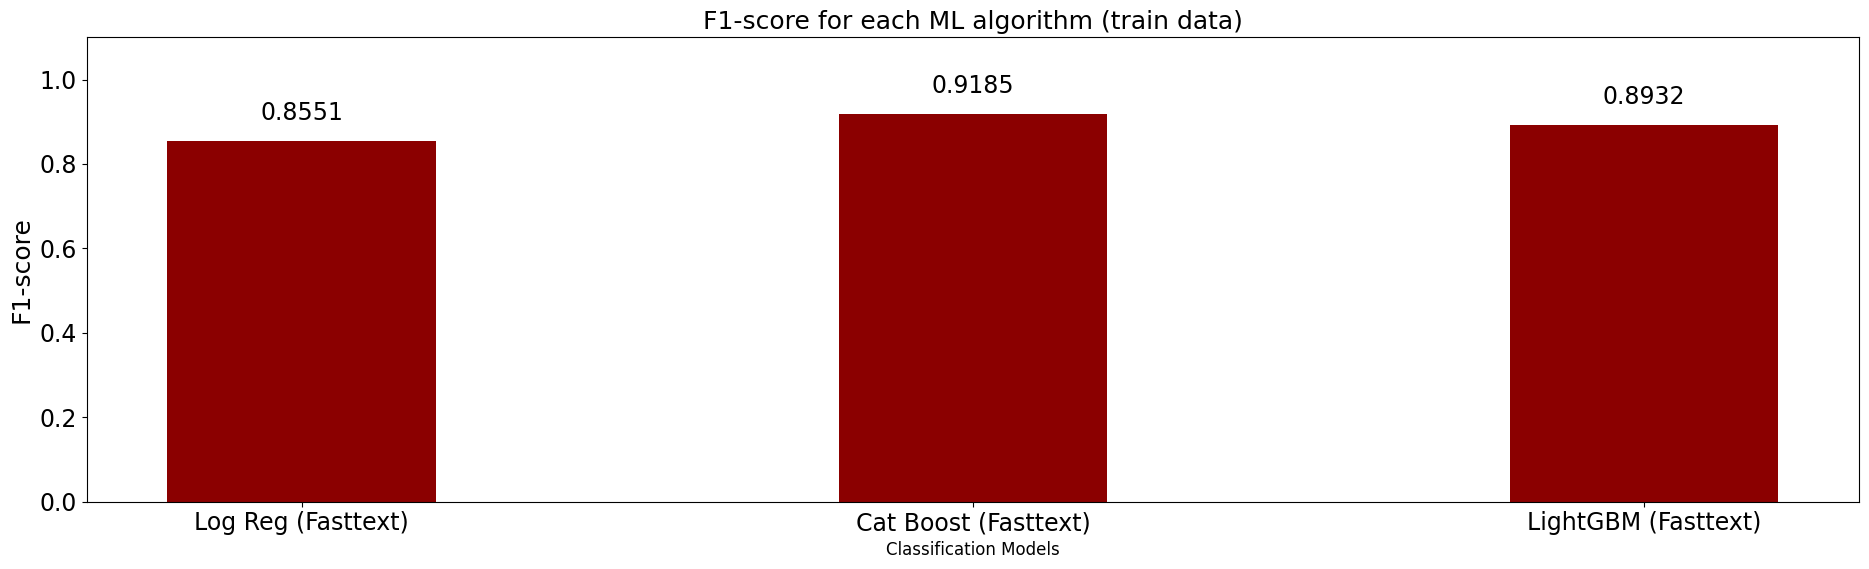

In [377]:
# Generate F1-score plots

plt.rcParams.update({'font.size': 17,
                     'text.color' : 'black',
                     'axes.labelcolor' : "blue"})
# plt.rcParams.update({'axes.titlesize': 'large'})
fig, ax = plt.subplots(figsize=(19, 6))

x = ['Log Reg (Fasttext)',
     'Cat Boost (Fasttext)',
    'LightGBM (Fasttext)']

y = [best_score_logreg,
     best_score_catboost,
     best_score_LGBM]

ax.bar(x, y, width=0.4, color='darkred')
ax.set_title('F1-score for each ML algorithm (train data)', fontsize=18)
ax.set_xlabel('Classification Models', fontsize=12)
ax.set_ylabel('F1-score', fontsize=18)
ax.set_ylim(0, 1.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')

plt.tight_layout();

### *Вывод:* Видим, что наилучший скор у CatBoost классификатора. Следом за ним - идет градиентный бустинг. Проведем тесты на реальных данных, чтобы принять окончательное решение.

## Тестирование моделей на реальных данных

In [379]:
complaints.head()

,date,category,topic,municipality,text,label
25621,2022-06-22 21:53:53.433,Жалоба,Дороги,Северодвинск г,'На съезде с моста Ягринского в сторону Ягр ог...,complaint
12141,2022-03-24 08:34:51.534,Жалоба,Дороги,Белгород г,"'Добрый день. Организуйте, пожалуйста, тротуар...",complaint
2264,2022-04-04 17:14:19.799,Жалоба,Общественный транспорт,Челябинск г,'75 вообще плохо стала ходить,complaint


In [380]:
print("Примеры жалобы:")
for i, row in complaints.sample(n=3).iterrows():
    print(row['text'])
    print()

Примеры жалобы:
'Добрый день. Организуйте, пожалуйста, тротуар/велодорожку/что-нибудь кроме автодороги из Новой Жизни в центр. Управа смогла лишь поставить бетонные блоки, засыпать грязь компетенций не хватило. Начинается очередное лето, когда можно выбраться не только на автомобиле, но и пешком, на велосипеде, самокате, а это болото вынуждает дожидаться как минимум мая пока оно высохнет.

'75 вообще плохо стала ходить

'На съезде с моста Ягринского в сторону Ягр огромная дыра в стыке. Ее залейте раз и навсегда !



In [381]:
questions.head()

,date,category,topic,municipality,text,label
19936,2022-02-01 14:23:00.895,Вопрос,Коронавирус,Уфа г,'[club112525122|Министерство образования и нау...,question
4586,2022-03-31 03:48:40.700,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,"'[id257399570:bp-53367440_124408|Ирина], Здрав...",question
29154,2022-07-02 08:13:51.505,Вопрос,Здравоохранение/Медицина,Виноградовский р-н,'Когда уже откроют новую больницу?,question


In [382]:
test1 = [complaints['text'].iloc[0]] # complaint
test2 = [complaints['text'].iloc[1]] # complaint
test3 = [complaints['text'].iloc[2]] # complaint

test4 = [questions['text'].iloc[0]] # question
test5 = [questions['text'].iloc[1]] # question
test6 = [questions['text'].iloc[2]] # question

In [383]:
test_data = pd.DataFrame({
    'text': [test1[0], test2[0], test3[0], test4[0], test5[0], test6[0]],
    'category': ['complaint', 'complaint', 'complaint', 'question', 'question', 'question']
})
test_data

,text,category
0,'На съезде с моста Ягринского в сторону Ягр ог...,complaint
1,"'Добрый день. Организуйте, пожалуйста, тротуар...",complaint
2,'75 вообще плохо стала ходить,complaint
3,'[club112525122|Министерство образования и нау...,question
4,"'[id257399570:bp-53367440_124408|Ирина], Здрав...",question
5,'Когда уже откроют новую больницу?,question


In [384]:
test_data['ft_embedding'] = test_data['text'].apply(lambda x: get_com_embedding(x, model=ft, embedding_size=300))

print(logreg_grid.predict(list(test_data['ft_embedding'])))
print(gsearch_catboost.predict(list(test_data['ft_embedding'])))
print(LGBMClassifier_gsearch.predict(list(test_data['ft_embedding'])))

['complaint' 'complaint' 'complaint' 'complaint' 'question' 'question']
['question' 'question' 'question' 'question' 'question' 'question']
['question' 'complaint' 'complaint' 'complaint' 'question' 'question']


In [386]:
test_data['pred_logreg'] = logreg_grid.predict(list(test_data['ft_embedding']))
test_data['pred_catboost'] = gsearch_catboost.predict(list(test_data['ft_embedding']))
test_data['pred_lightGBM'] = LGBMClassifier_gsearch.predict(list(test_data['ft_embedding']))

test_data

,text,category,ft_embedding,pred_logreg,pred_catboost,pred_lightGBM
0,'На съезде с моста Ягринского в сторону Ягр ог...,complaint,"[0.003900327176476518, -0.007384898173364086, ...",complaint,question,question
1,"'Добрый день. Организуйте, пожалуйста, тротуар...",complaint,"[-0.003422631702851504, -0.012711150939576327,...",complaint,question,complaint
2,'75 вообще плохо стала ходить,complaint,"[0.019425440207123758, -0.06504354029893875, 0...",complaint,question,complaint
3,'[club112525122|Министерство образования и нау...,question,"[0.01623209557993422, -0.011629841885190796, -...",complaint,question,complaint
4,"'[id257399570:bp-53367440_124408|Ирина], Здрав...",question,"[0.035537443589419127, -0.014346741728092494, ...",question,question,question
5,'Когда уже откроют новую больницу?,question,"[0.0069507196545600895, 0.009050874598324299, ...",question,question,question


In [387]:
actuals = test_data[['category', 'pred_logreg', 'pred_catboost', 'pred_lightGBM']]
actuals

,category,pred_logreg,pred_catboost,pred_lightGBM
0,complaint,complaint,question,question
1,complaint,complaint,question,complaint
2,complaint,complaint,question,complaint
3,question,complaint,question,complaint
4,question,question,question,question
5,question,question,question,question


### *Вывод:* Видим, что CatBoost ошибка на всех тестах и не научился определять жалобу. В то время, как логистическая регрессия и бустинг прошли 5 из 6-ти тестов успешно. Так как бустинг показывает более высокий скор, то можно выбрать эту модель как наиболее подходящую для предсказаний.